### Evaluating global and local structure preservation by dimensionality reduction methods
C. Heiser, June 2019

---
The purpose of this notebook is to demonstrate use of `fcc_DRs.py` and `fcc_utils.py` functions for evaluating data structure preservation in low-dimensional latent spaces.  
See [fcc_classes_tutorial.ipynb](fcc_classes_tutorial.ipynb) for complete functionality of **RNA_counts** and **DR** Python objects.

In [1]:
from fcc_DRs import * # contains dimensionality reduction classes
from fcc_utils import * # contains functions for comparing native and latent spaces

Let's say we have a raw counts file from a scRNA-seq experiment, and we've used some computational tool to reduce the dimensionality of our dataset for visualization and clustering.  
If we have our native (counts) and latent spaces defined as cell-by-feature matrices in tab- or comma-delimited format, we can quickly and easily visualize the global data structure preservation between the two.

In [5]:
# read in native space (counts matrix). this one is cells x genes (cells_axis=0), with cell and gene labels in the first column and row, respectively (labels=[0,0])
native = RNA_counts.from_file(datafile='inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', cells_axis=0, labels=[0,0])

In [4]:
# read in latent space (feature matrix). this one is cells x features (cells_axis=0), with no cell or feature labels (labels=[None,None])
latent = DR.from_file(datafile='dev/outputs/colon_UMAP.csv', cells_axis=0, labels=[None,None], name='UMAP')

We should have a native space with **500 genes** in this case, and a latent space with **2 features**, or dimensions, of the `UMAP` embedding of our data.  
Let's double-check this with the `.data` and `.results` attributes of our `RNA_counts` and `DR` objects, respectively.

In [6]:
native.data.shape

(1117, 500)

In [7]:
latent.results.shape

(1117, 2)

We can go ahead and plot our latent UMAP space:

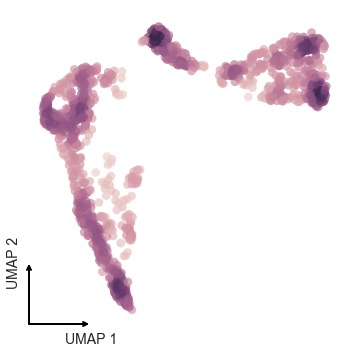

In [8]:
latent.plot()

That one is colored by point density in UMAP space.  
We can also color each cell (point) by total UMI using our native gene matrix: 

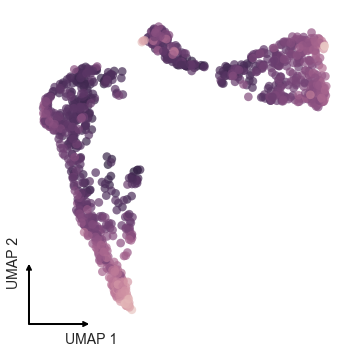

In [9]:
latent.plot(color=native.arcsinh_norm().sum(axis=1))

Or we can use our native space to overlay expression of specific genes on the embedding:

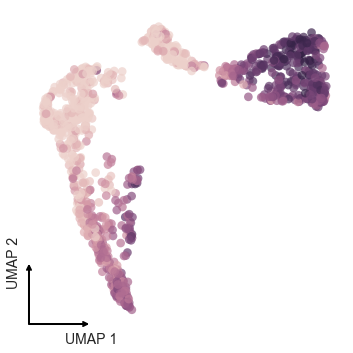

In [20]:
latent.plot(color=native.arcsinh_norm()[:,native.gene_IDs.str.contains('Krt20$')].flatten())

In order to visualize what's going on in our *native* space, we can perform a PCA and plot the variance contribution of each PC.

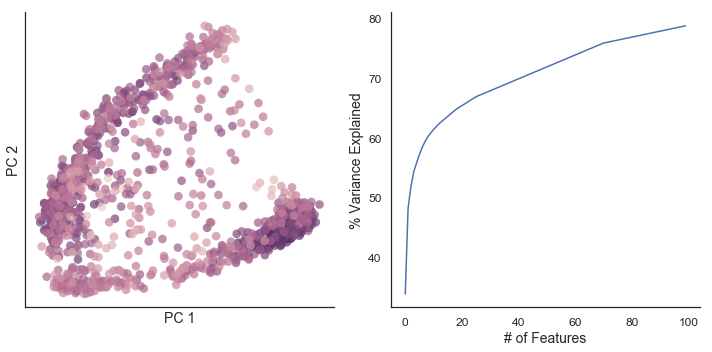

In [21]:
PCA = fcc_PCA(matrix=native.arcsinh_norm(), n_components=100) # 100 PCs
PCA.plot_PCA()

Now let's get down to some structure comparisons.  
We can use the `distance_stats` and `knn_preservation` functions to return Z-score normalized **distance distributions**, **correlation statistics**, **EMD** value, and **Knn preservation**.

In [22]:
native_norm, latent_norm, mantel_stats, EMD = distance_stats(pre=native.distance_matrix(transform='arcsinh'), post=latent.distance_matrix()) # arcsinh-normalize counts for comparison to native space
knn = knn_preservation(pre=native.knn_graph(k=30, transform='arcsinh'), post=latent.knn_graph(k=30)) # use 30 nearest-neighbors
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

R: 0.8002
EMD: 0.0936
Knn Pres.: 97.1171


Now, we can plot our distance distributions and correlation using the `plot_cumulative_distributions` and `joint_plot_distance_correlation` functions:

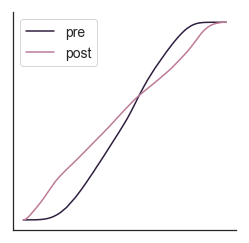

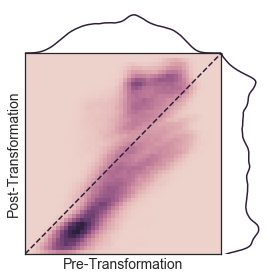

In [24]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(native_norm, latent_norm)

joint_plot_distance_correlation(native_norm, latent_norm)

---
#### Local structure evaluation
Now that we see the overall structural preservation of our native space by UMAP, let's 'zoom-in' on one cluster to see how it is preserved.  
If we have cluster IDs saved as a tab- or comma-delimited file, we can read it in with our `RNA_counts` and `DR` objects.

In [40]:
# we need to have no cell labels in our native space for this one, since the barcodes are associated by index:
native = RNA_counts.from_file(datafile='inputs/GSM2743164_rep1_colon_rnaseq.processed.norowlabels.tsv.gz', cells_axis=0, labels=[None,0], barcodefile='dev/outputs/colon_clu.csv')
latent = DR.from_file(datafile='dev/outputs/colon_UMAP.csv', cells_axis=0, labels=[None,None], name='UMAP', barcodefile='dev/outputs/colon_clu.csv')

We can look at the barcode, or cluster, membership within our dataset, and plot them on our UMAP embedding.

In [41]:
latent.barcode_counts()

0.0    274
1.0    273
2.0    167
3.0    140
4.0    135
5.0    128
Name: Barcode, dtype: int64

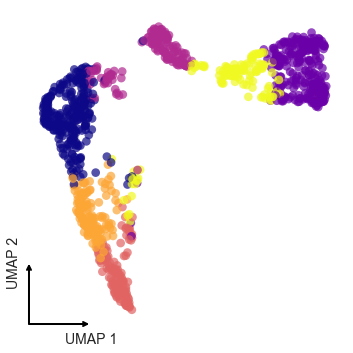

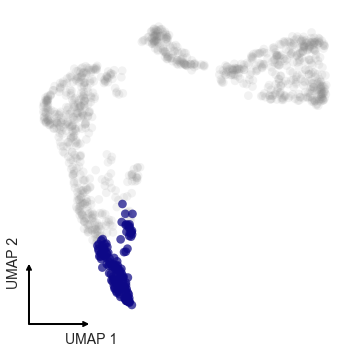

In [42]:
latent.plot_barcodes()
latent.plot_barcodes(ranks=['3'])

CPU times: user 9.97 s, sys: 310 ms, total: 10.3 s
Wall time: 9.75 s


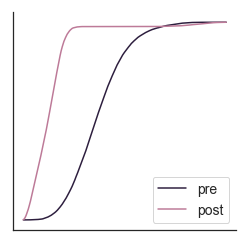

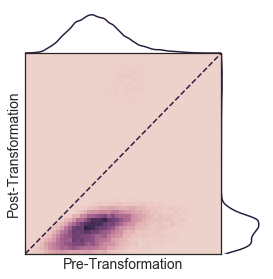

In [75]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

Let's look at the distance preservation within cluster **'3'**, shown above.

In [43]:
native_norm, latent_norm, mantel_stats, EMD = distance_stats(pre=native.distance_matrix(transform='arcsinh', ranks=['3']), post=latent.distance_matrix(ranks=['3'])) # arcsinh-normalize counts for comparison to native space
knn = knn_preservation(pre=native.knn_graph(k=30, transform='arcsinh', ranks=['3']), post=latent.knn_graph(k=30, ranks=['3'])) # use 30 nearest-neighbors
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

R: 0.5708
EMD: 0.1174
Knn Pres.: 79.398


Now, we can plot our distance distributions and correlation using the `plot_cumulative_distributions` and `joint_plot_distance_correlation` functions:

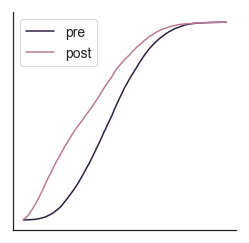

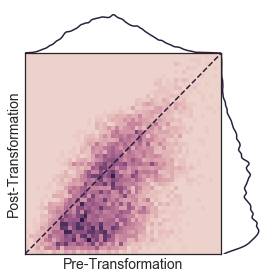

In [44]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(native_norm, latent_norm)

joint_plot_distance_correlation(native_norm, latent_norm)

#### Neighborhood structure evaluation
Finally, if we want to see the arrangement of clusters in our low-dimensional embedding, we can calculate pairwise distances between cells in three clusters and plot them together.
Let's look at the colonocyte lineage from our colon dataset:

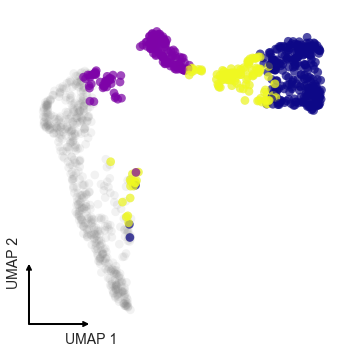

In [48]:
latent.plot_barcodes(ranks=['1','2','5'])

Here, we use our wrapper function `cluster arrangement`, which returns a nice aggregate 2D histogram of our 'cluster triangle', and calculated correlation and EMD values between each pair of clusters.

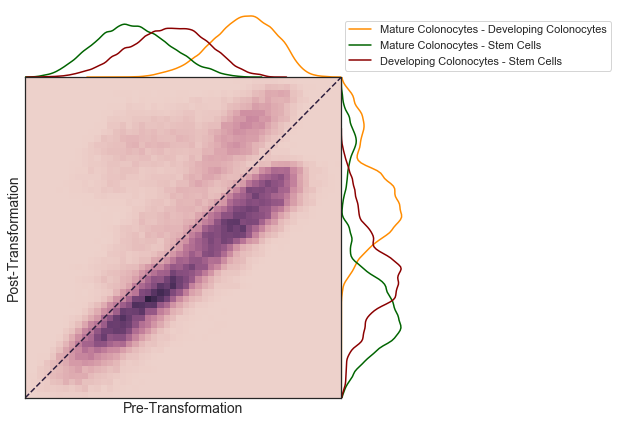

In [49]:
EMD, corr_stats = cluster_arrangement(pre_obj=native, post_obj=latent, clusters=['1','2','5'], cluster_names=['Mature Colonocytes','Developing Colonocytes','Stem Cells'])